In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
class VAE(nn.Module):
    def __init__(self,input_dimension,hidden_dimension,z_dimension):
        super().__init__()
        self.input_dimension=input_dimension
        self.hidden_dimension=hidden_dimension
        self.z_dimension=z_dimension

        # Define the encoder network
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dimension, self.hidden_dimension),
            nn.ReLU(),
        )

        # Define the mean and variance layers for the latent space
        self.mean = nn.Linear(self.hidden_dimension,self.z_dimension)
        self.variance = nn.Linear(self.hidden_dimension,self.z_dimension)

        # Define the decoder network
        self.decoder = nn.Sequential(
            nn.Linear(self.z_dimension, self.hidden_dimension),
            nn.ReLU(),
            nn.Linear(self.hidden_dimension, self.input_dimension),
            nn.Sigmoid(),
        )

    def reparameterize(self, mean, variance):
        #std = torch.exp(0.5 * variance)
        eps = torch.randn_like(variance)
        z = mean + eps * variance
        return z

    def forward(self, x):
        # Encode the input

        h = self.encoder(x)

        # Compute the mean and variance of the latent space
        mean = self.mean(h)
        variance = self.variance(h)

        # Reparameterize the latent space
        z = self.reparameterize(mean, variance)

        # Decode the latent space
        x_recon = self.decoder(z)

        return x_recon, mean, variance


In [12]:
# Define the reconstruction loss (binary cross-entropy) and KL divergence loss
def reconstruction_loss(x_recon, x):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    return recon_loss


def kl_divergence_loss(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dimension = 784
z_dimension = 20
hidden_dimension = 200
epochs = 10
batch_size=128

In [14]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Define train function
def train_vae(epochs, vae_model, optimizer):
    # Start training
    for epoch in range(epochs):
        for i, (x, _) in enumerate(train_loader):
            # Forward pass
            x = x.to(device).view(-1, input_dimension)
            x_recon, mean, variance = vae_model(x)

            # Compute the reconstruction loss and KL divergence loss
            recon_loss = reconstruction_loss(x_recon, x)
            kl_loss = kl_divergence_loss(mean, variance)

            # Compute the total loss
            loss = recon_loss + kl_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print the loss
            if (i+1) % 100 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Recon Loss: {:.4f}, KL Div Loss: {:.4f}"
                  .format(epoch+1, epochs, i+1, len(train_loader), loss.item(), recon_loss.item(), kl_loss.item()))


In [16]:
# Initialize model, optimizer, loss
vae = VAE(input_dimension, hidden_dimension,z_dimension).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.005)

# train
train_vae(epochs, vae, optimizer)

Epoch [1/10], Step [100/469], Loss: 16757.5020, Recon Loss: 16217.7686, KL Div Loss: 539.7329
Epoch [1/10], Step [200/469], Loss: 14680.4482, Recon Loss: 14240.0459, KL Div Loss: 440.4023
Epoch [1/10], Step [300/469], Loss: 13064.4160, Recon Loss: 12647.4658, KL Div Loss: 416.9498
Epoch [1/10], Step [400/469], Loss: 12868.7988, Recon Loss: 12488.3721, KL Div Loss: 380.4264
Epoch [2/10], Step [100/469], Loss: 11432.4971, Recon Loss: 11084.9648, KL Div Loss: 347.5327
Epoch [2/10], Step [200/469], Loss: 10945.3438, Recon Loss: 10621.0508, KL Div Loss: 324.2929
Epoch [2/10], Step [300/469], Loss: 11237.0576, Recon Loss: 10920.7979, KL Div Loss: 316.2598
Epoch [2/10], Step [400/469], Loss: 11104.1865, Recon Loss: 10801.1943, KL Div Loss: 302.9923
Epoch [3/10], Step [100/469], Loss: 10168.9766, Recon Loss: 9871.4004, KL Div Loss: 297.5764
Epoch [3/10], Step [200/469], Loss: 10389.3984, Recon Loss: 10112.5107, KL Div Loss: 276.8881
Epoch [3/10], Step [300/469], Loss: 10362.5459, Recon Loss: 1

In [17]:
def image_generation_and_display(num_examples):
    #make a list of img_tensor sorted according to digit
    img_tensor = []
    digit = 0
    for x, y in train_dataset:
        if y == digit:
            img_tensor.append(x)
            digit += 1
        if digit == 10:
            break
    
    #encoding
    encoded_digit = []
    for d in range(10):
        with torch.no_grad():
            z=vae.encoder(img_tensor[d].view(1, 784))
            mean=vae.mean(z)
            variance=vae.variance(z)
        encoded_digit.append((mean, variance))
    
    fig, axs = plt.subplots(10, num_examples, figsize=(10, 10))
    for i in range(10):
     mean, variance = encoded_digit[i]
     for j in range(num_examples):
        std = torch.randn_like(variance)
        z = mean + variance * std
        out = vae.decoder(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"img_{i}_ex{j}.png")
        img_path = f"img_{i}_ex{j}.png"
        img = Image.open(img_path).convert('L')
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
    plt.show()



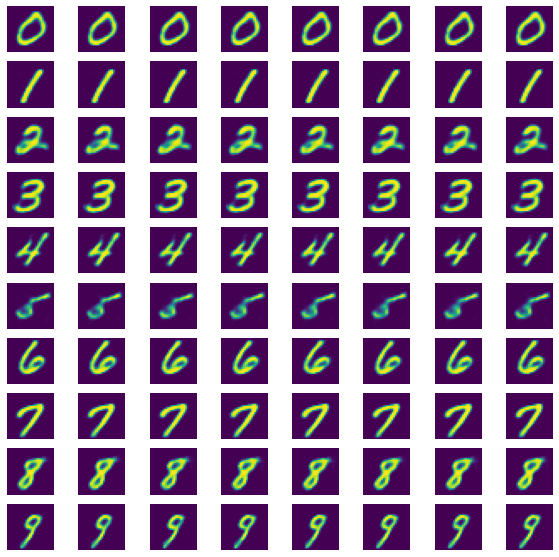

In [18]:
image_generation_and_display(8)